# Analysis of Processed and Filtered Data

**Imports**

In [232]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from disaster_extr_constants import *
from disaster_extr_helpers import df_time_interval
from sklearn import preprocessing

In [209]:
def extract_disaster(year,disaster_type, general=False):
    # General --> consider whole year datasets (not the specific disasters)
    if general:  
        disaster_path = 'data/'+str(year)+'_'+disaster_type+'_whole_year_csv.bz2'
        disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
        disaster_df_2 = None
        
        climate_path = 'data/'+str(year)+'_climate_whole_year_csv.bz2'
        climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')

        start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
    
    else:
        if year == 2018 and disaster_type == 'storm':
            disaster_path_asia = 'data/'+str(year)+'_'+disaster_type+'_filtered_asia_csv.bz2'
            disaster_path_america = 'data/'+str(year)+'_'+disaster_type+'_filtered_america_csv.bz2'

            disaster_df = pd.read_csv(disaster_path_asia, parse_dates = ['date'], compression='bz2')
            disaster_df_2 = pd.read_csv(disaster_path_america, parse_dates = ['date'], compression='bz2')

        else:
            disaster_path = 'data/'+str(year)+'_'+disaster_type+'_filtered_csv.bz2'
            disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
            disaster_df_2 = None

        climate_path = 'data/'+str(year)+'_'+disaster_type+'_climate_filtered_csv.bz2'
        climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')

        start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
    
        if year == 2018 and disaster_type == 'storm':
            start_disaster_2, end_disaster_2 = disaster_df_2.date.min(), disaster_df_2.date.max()

            start_disaster = min([start_disaster,start_disaster_2])
            end_disaster = min([end_disaster,end_disaster_2])
    
    start_climate, end_climate = climate_df.date.min(), climate_df.date.max()
    
    return (climate_df, start_climate, end_climate), (disaster_df, start_disaster, end_disaster), disaster_df_2

In [210]:
def create_hist_comparison(year,disaster_type,general=False):
        
    all_data = extract_disaster(year,disaster_type,general)
    
    (climate_df, start_climate, end_climate) = all_data[0]
    (disaster_df, start_disaster, end_disaster) = all_data[1]
    disaster_df_2 = all_data[2]
    
    if disaster_df_2:
        dscr_str = 'Asia'
        dscr_str_2 = 'America'
    else:
        dscr_str = ''
    
    print("Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print("Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + ' Storm ',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    
    _, bins, _ = plt.hist(
        climate_df.date, 
        bins=60, 
        weights=climate_df.numOccurrences,
        alpha=0.4,
        label='Climate Talk', 
        log=True)
    
    plt.hist(
        disaster_df.date, 
        bins=bins, 
        weights=disaster_df.numOccurrences,
        alpha=0.7,
        label=type_to_str[disaster_type]+dscr_str+' Talk')
    
    if disaster_df_2:
        plt.hist(
            disaster_df_2.date, 
            bins=bins, 
            weights=disaster_df_2.numOccurrences,
            alpha=0.3,
            label=type_to_str[disaster_type]+dscr_str_2+' Talk')
    
    plt.xlabel("Time")
    plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='upper left')
    plt.show()

In [285]:
def create_plot_comparison(year,disaster_type,general=False,resample=None, normalize=False, log=True):
        
    all_data = extract_disaster(year,disaster_type,general)
    
    (climate_df, start_climate, end_climate) = all_data[0]
    (disaster_df, start_disaster, end_disaster) = all_data[1]
    disaster_df_2 = all_data[2]
    
    if resample:
        climate_df = climate_df.set_index('date').resample(resample).sum().dropna().reset_index()
        disaster_df = disaster_df.set_index('date').resample(resample).sum().dropna().reset_index()
        
        if normalize:
            x_climate = climate_df.numOccurrences.values.reshape(-1, 1)
            min_max_scaler = preprocessing.MinMaxScaler()
            x_climate_scaled = min_max_scaler.fit_transform(x_climate)
            climate_df.numOccurrences = pd.DataFrame(x_climate_scaled)
            
            x_disaster = disaster_df.numOccurrences.values.reshape(-1, 1)
            min_max_scaler = preprocessing.MinMaxScaler()
            x_disaster_scaled = min_max_scaler.fit_transform(x_disaster)
            disaster_df.numOccurrences = pd.DataFrame(x_disaster_scaled)
    
    if disaster_df_2:
        dscr_str = 'Asia'
        dscr_str_2 = 'America'
        if resample:
            disaster_df_2 = disaster_df_2.set_index('date').resample(resample).sum().dropna().reset_index()
            
            if normalize:
                x_disaster_2 = disaster_df_2.numOccurrences.values.reshape(-1, 1)
                min_max_scaler = preprocessing.MinMaxScaler()
                x_disaster_2_scaled = min_max_scaler.fit_transform(x_disaster_2)
                disaster_df_2.numOccurrences = pd.DataFrame(x_disaster_2_scaled, columns=disaster_df_2.columns)
    else:
        dscr_str = ''
    
    print("Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print("Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + ' Storm ',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    
    plt.plot(
    climate_df.date,  
    climate_df.numOccurrences,
    alpha=0.4,
    label='Climate Talk')
    
    plt.plot(
    disaster_df.date,  
    disaster_df.numOccurrences,
    alpha=0.7,
    label=type_to_str[disaster_type]+dscr_str+' Talk')
    
    if disaster_df_2:
        plt.plot(
        disaster_df_2.date,  
        disaster_df_2.numOccurrences,
        alpha=0.3,
        label=type_to_str[disaster_type]+dscr_str_2+' Talk')
        
    if log:   
        plt.yscale('log')
    plt.xlabel("Time")
    plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='upper left')
    plt.show()

In [239]:
all_data = extract_disaster(year=2019,disaster_type='heat_wave',general=True)

In [263]:
(climate_df, start_climate, end_climate) = all_data[0]
(disaster_df, start_disaster, end_disaster) = all_data[1]

In [264]:
climate_df = climate_df.set_index('date').resample('1W').sum().dropna().reset_index()
disaster_df = disaster_df.set_index('date').resample('1W').sum().dropna().reset_index()

In [265]:
climate_df

date  numOccurrences
0  2019-01-06            3539
1  2019-01-13            5487
2  2019-01-20            8043
3  2019-01-27            8427
4  2019-02-03            7844
5  2019-02-10           10147
6  2019-02-17            7478
7  2019-02-24            7763
8  2019-03-03            8603
9  2019-03-10            7420
10 2019-03-17           11042
11 2019-03-24            8444
12 2019-03-31           10065
13 2019-04-07            8918
14 2019-04-14            8131
15 2019-04-21            4048
16 2019-04-28            4481
17 2019-05-05           11794
18 2019-05-12           10728
19 2019-05-19           11507
20 2019-05-26            9621
21 2019-06-02            9568
22 2019-06-09           14521
23 2019-06-16           10779
24 2019-06-23           11509
25 2019-06-30            9203
26 2019-07-07            5208
27 2019-07-14            7374
28 2019-07-21            5249
29 2019-07-28            4758
30 2019-08-04            6274
31 2019-08-11            6477
32 2019-08-18           28288
33 2019-08-25            8595
34 2019-09-01            7767
35 2019-09-08            9454
36 2019-09-15           10686
37 2019-09-22           13891
38 2019-09-29           15646
39 2019-10-06            8467
40 2019-10-13           10435
41 2019-10-20           10580
42 2019-10-27            9094
43 2019-11-03            9365
44 2019-11-10           11373
45 2019-11-17           11922
46 2019-11-24           10272
47 2019-12-01            9884
48 2019-12-08           12837
49 2019-12-15           11435
50 2019-12-22            8725
51 2019-12-29            3651
52 2020-01-05            1592

In [266]:
x_climate = climate_df.numOccurrences.values.reshape(-1, 1)

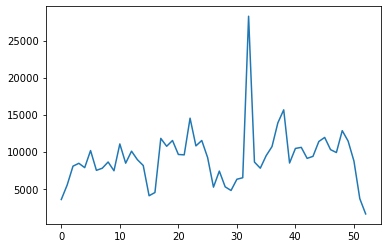

In [267]:
plt.plot(x_climate)

In [268]:
min_max_scaler = preprocessing.MinMaxScaler()
x_climate_scaled = min_max_scaler.fit_transform(x_climate)

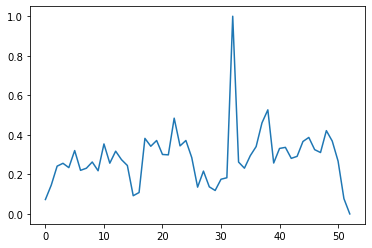

In [269]:
plt.plot(x_climate_scaled)

In [270]:
climate_df.numOccurrences = pd.DataFrame(x_climate_scaled)

<AxesSubplot:xlabel='date'>

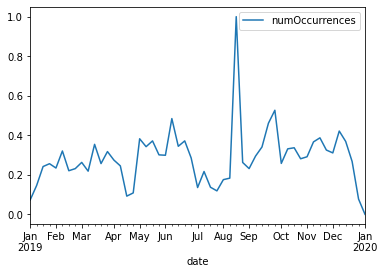

In [279]:
climate_df.plot(x=0,y=1)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


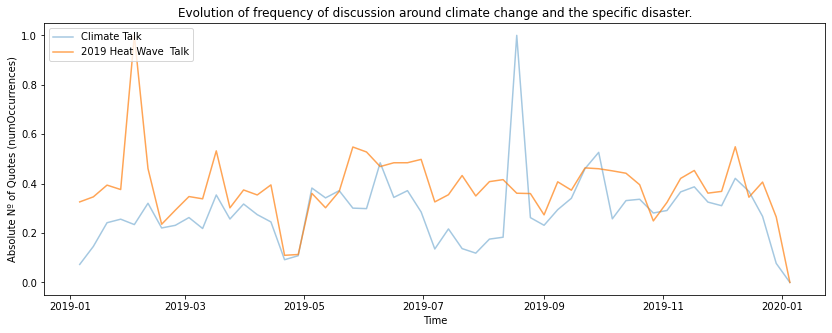

In [286]:
create_plot_comparison(year=2019,disaster_type='heat_wave',general=True,resample='1W', normalize=True, log=False)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


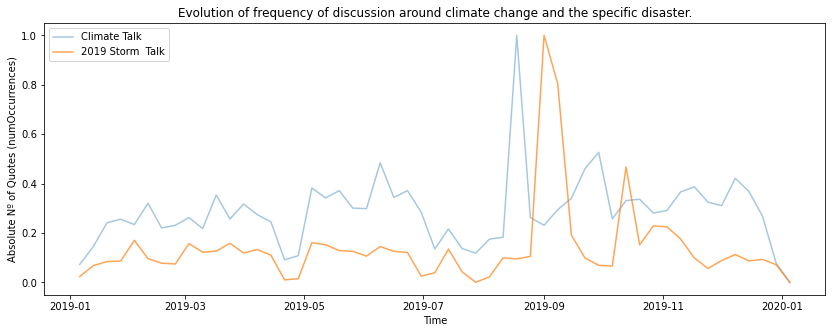

In [287]:
create_plot_comparison(year=2019,disaster_type='storm',general=True,resample='1W', normalize=True, log=False)

In [161]:
disaster_type = 'heat_wave'

Disaster Dates: 2015-05-20 --- 2015-06-09
Climate Dates:  2015-04-29 --- 2015-06-20


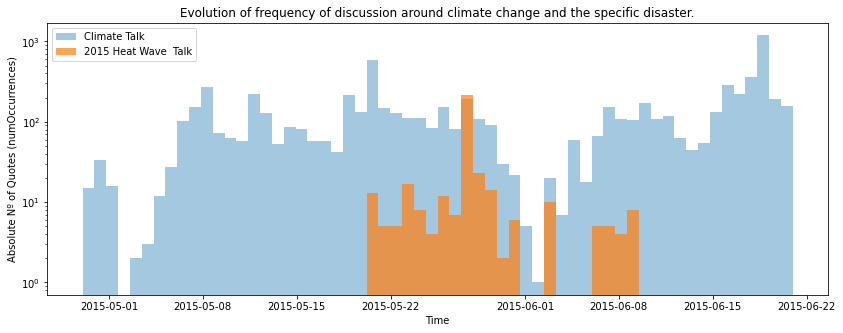

In [162]:
create_hist_comparison(2015,disaster_type)

Disaster Dates: 2016-04-17 --- 2016-05-20
Climate Dates:  2016-03-11 --- 2016-05-20


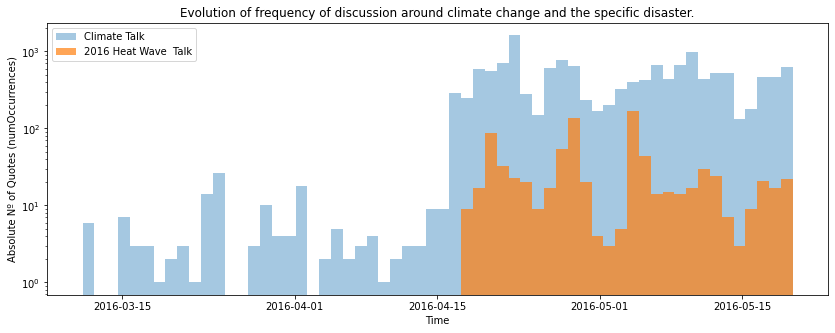

In [155]:
create_hist_comparison(2016,disaster_type)

Disaster Dates: 2017-01-31 --- 2017-02-24
Climate Dates:  2017-01-11 --- 2017-03-07


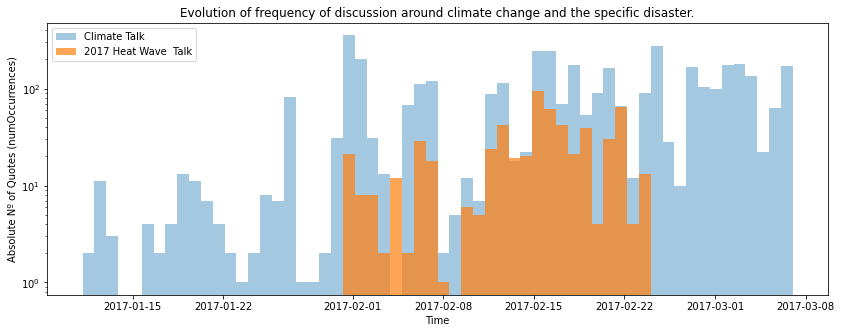

In [156]:
create_hist_comparison(2017,disaster_type)

Disaster Dates: 2018-07-01 --- 2018-08-03
Climate Dates:  2018-06-10 --- 2018-08-03


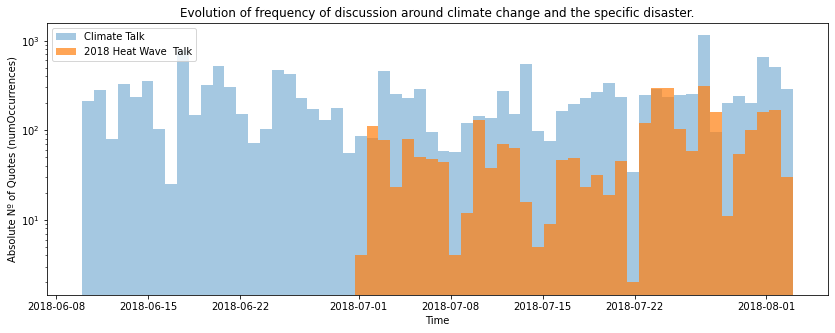

In [157]:
create_hist_comparison(2018,disaster_type)

Disaster Dates: 2019-07-19 --- 2019-08-05
Climate Dates:  2019-06-28 --- 2019-08-17


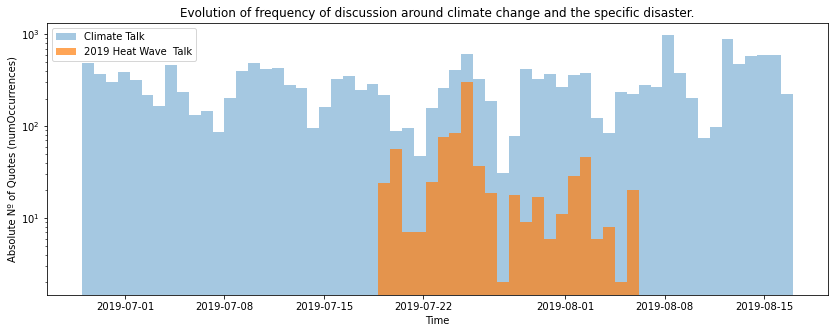

In [158]:
create_hist_comparison(2019,disaster_type)

Disaster Dates: 2019-09-02 --- 2020-01-31
Climate Dates:  2019-08-11 --- 2020-02-01


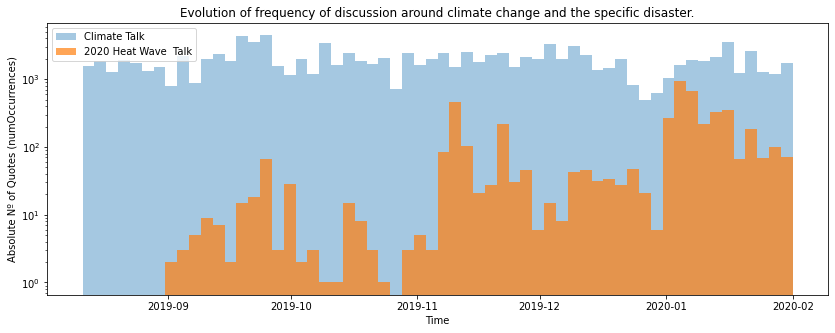

In [135]:
create_hist_comparison(2020,disaster_type)

In [136]:
disaster_type = 'storm'

Disaster Dates: 2015-10-22 --- 2015-11-06
Climate Dates:  2015-10-01 --- 2015-11-18


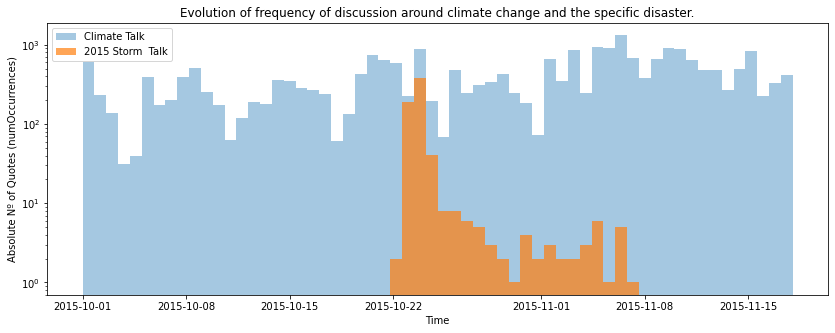

In [137]:
create_hist_comparison(2015,disaster_type)

Disaster Dates: 2016-02-18 --- 2016-02-26
Climate Dates:  2016-01-30 --- 2016-03-11


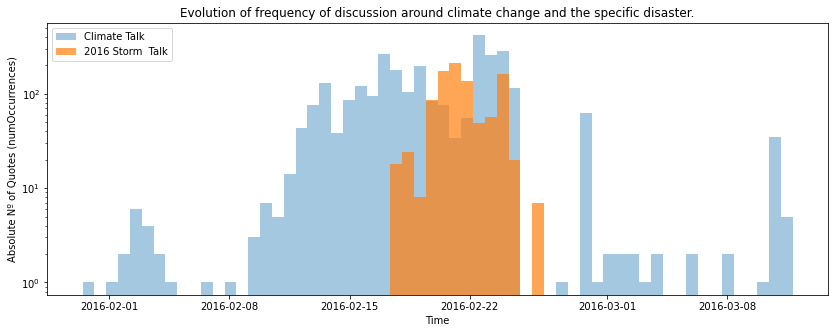

In [138]:
create_hist_comparison(2016,disaster_type)

Disaster Dates: 2017-08-23 --- 2017-09-08
Climate Dates:  2017-08-04 --- 2017-09-19


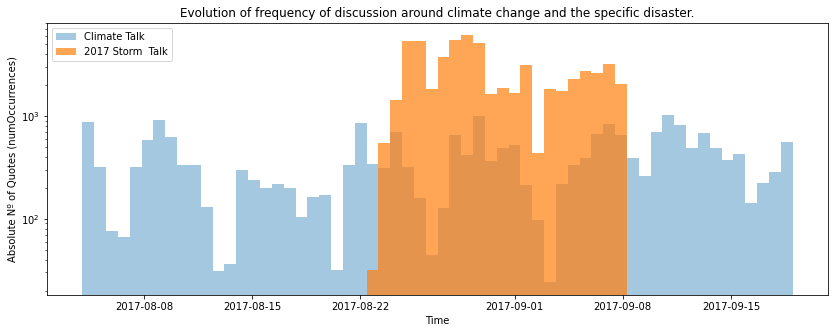

In [139]:
create_hist_comparison(2017,disaster_type)

Disaster Dates: 2018-09-08 --- 2018-09-27
Climate Dates:  2018-08-20 --- 2018-10-09


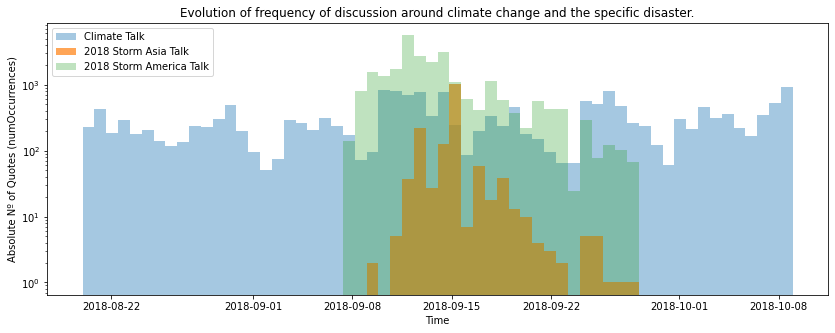

In [140]:
create_hist_comparison(2018,disaster_type)

Disaster Dates: 2019-10-07 --- 2019-10-27
Climate Dates:  2019-09-21 --- 2019-11-07


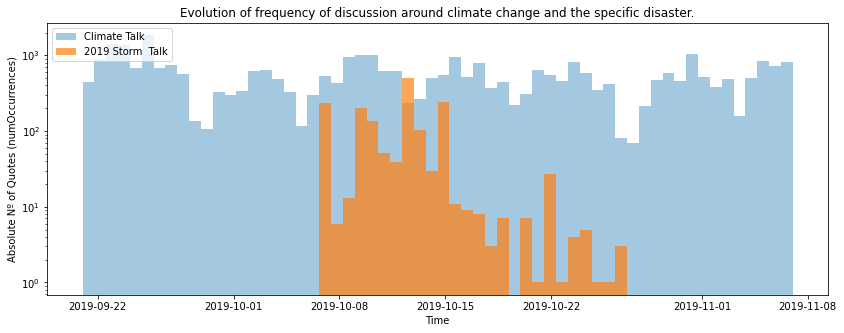

In [141]:
create_hist_comparison(2019,disaster_type)

Disaster Dates: 2019-12-02 --- 2019-12-12
Climate Dates:  2019-11-11 --- 2019-12-24


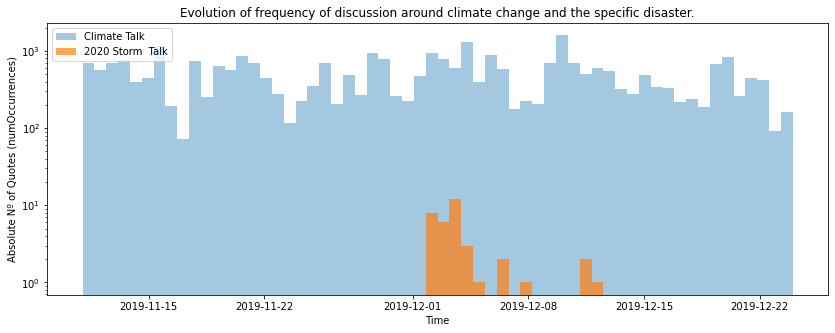

In [142]:
create_hist_comparison(2020,disaster_type)

**General Plots**

In [206]:
disaster_type = 'heat_wave'

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


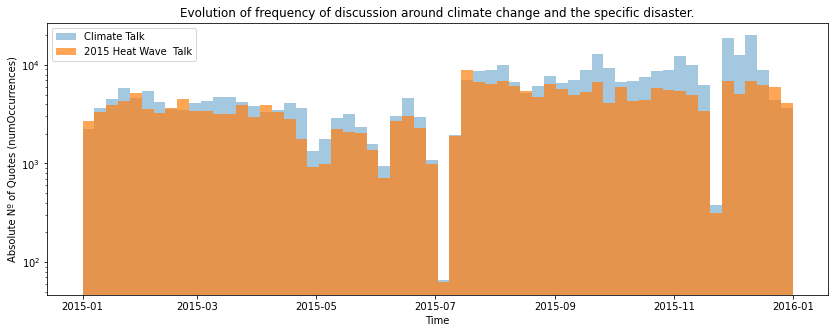

In [211]:
create_hist_comparison(2015,disaster_type,general=True)

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


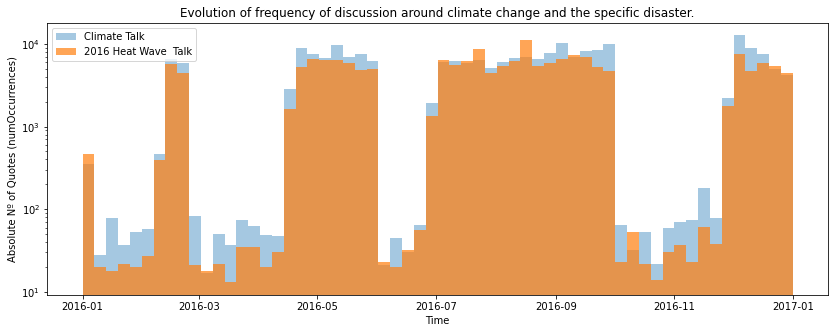

In [212]:
create_hist_comparison(2016,disaster_type,general=True)

Disaster Dates: 2017-01-01 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


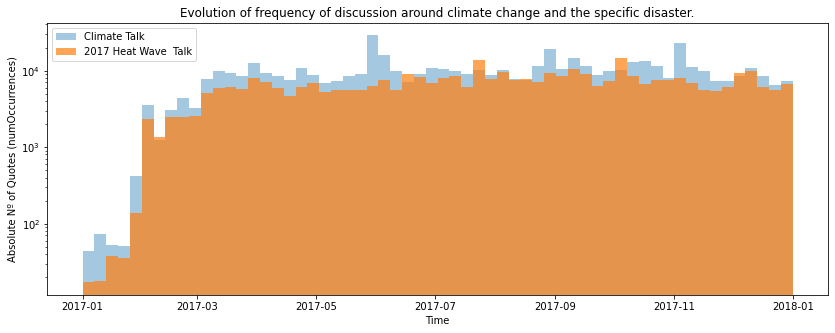

In [213]:
create_hist_comparison(2017,disaster_type,general=True)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


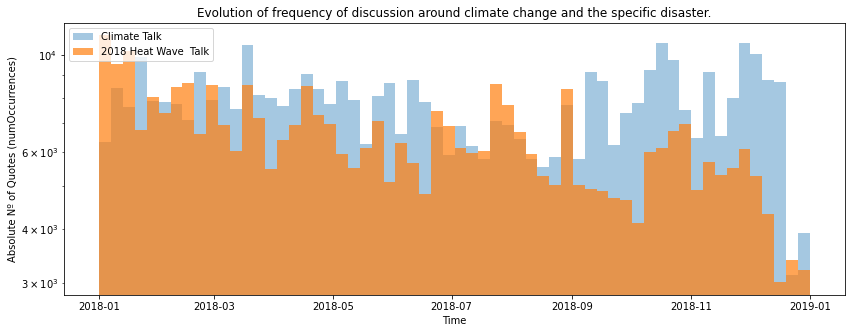

In [214]:
create_hist_comparison(2018,disaster_type,general=True)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


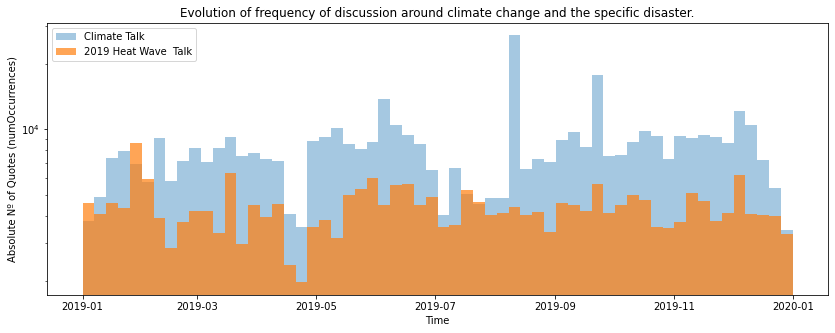

In [215]:
create_hist_comparison(2019,disaster_type,general=True)

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


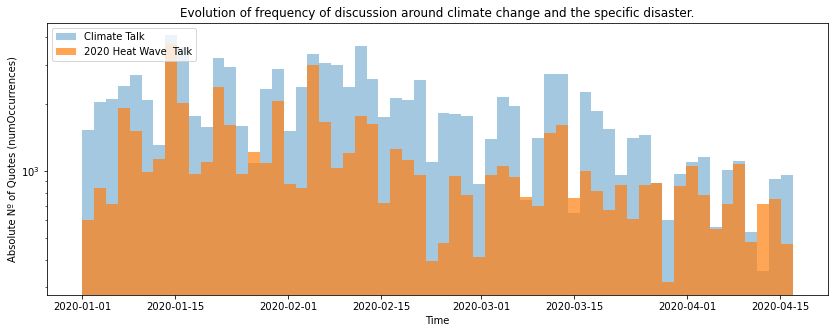

In [216]:
create_hist_comparison(2020,disaster_type,general=True)

In [217]:
disaster_type = 'storm'

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


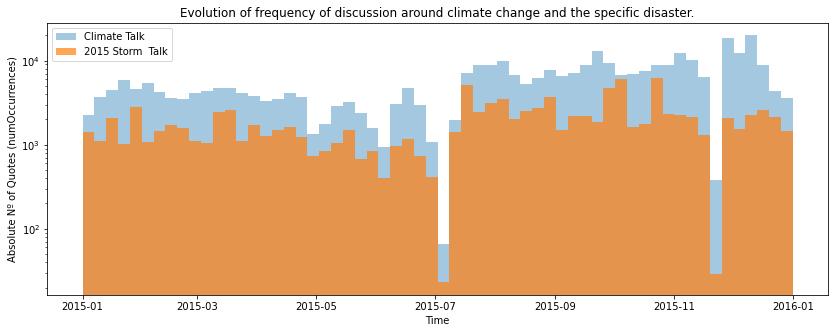

In [218]:
create_hist_comparison(2015,disaster_type,general=True)

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


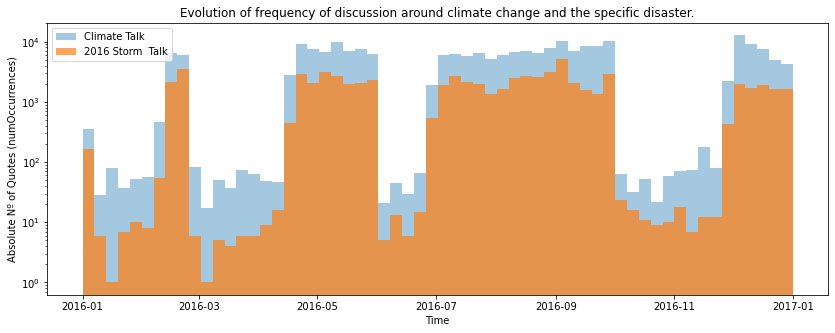

In [219]:
create_hist_comparison(2016,disaster_type,general=True)

Disaster Dates: 2017-01-03 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


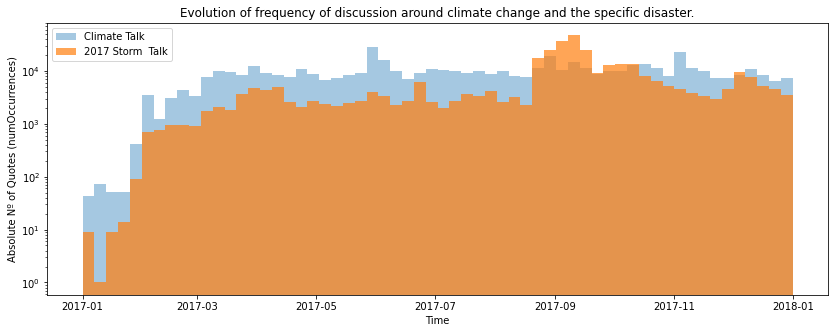

In [220]:
create_hist_comparison(2017,disaster_type,general=True)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


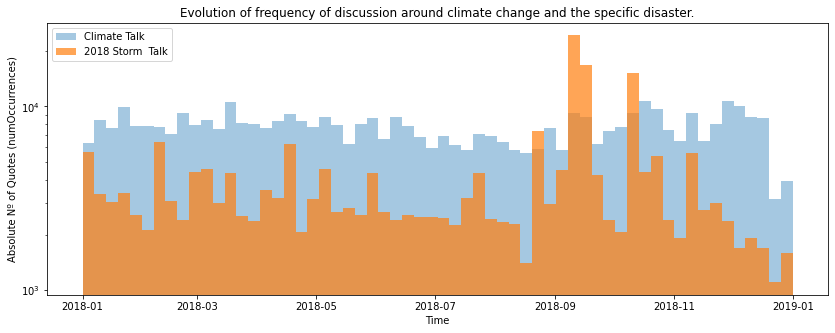

In [221]:
create_hist_comparison(2018,disaster_type,general=True)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


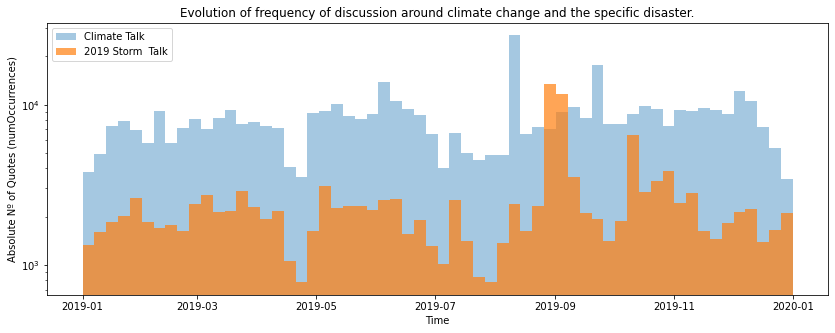

In [222]:
create_hist_comparison(2019,disaster_type,general=True)

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


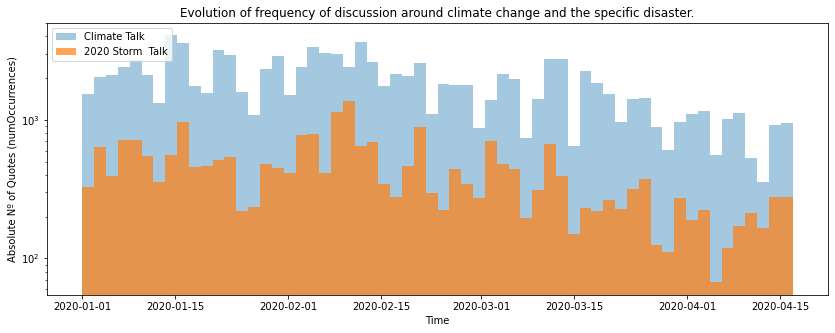

In [223]:
create_hist_comparison(2020,disaster_type,general=True)

In [198]:
all_data = extract_disaster(year=2018,disaster_type='storm')

(climate_df, start_climate, end_climate) = all_data[0]
(disaster_df, start_disaster, end_disaster) = all_data[1]
disaster_df_2 = all_data[2]

In [199]:
climate_df_sampled = climate_df.set_index('date').resample('2D').sum().dropna().reset_index()

In [200]:
disaster_df_sampled = disaster_df.set_index('date').resample('2D').sum().dropna().reset_index()

In [201]:
climate_limited = df_time_interval(climate_df, start_disaster, end_disaster, date_attr='date')

<AxesSubplot:xlabel='date'>

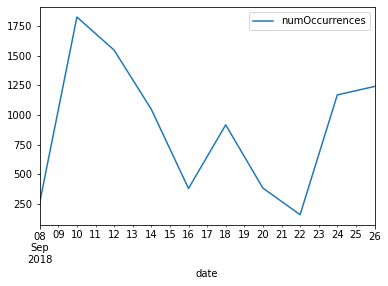

In [202]:
climate_limited.set_index('date').resample('2D').sum().dropna().reset_index().plot(x='date', y='numOccurrences')

<AxesSubplot:xlabel='date'>

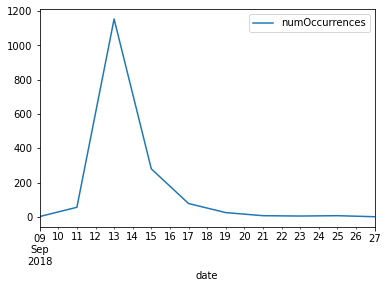

In [203]:
disaster_df.set_index('date').resample('2D').sum().dropna().reset_index().plot(x='date', y='numOccurrences')

In [204]:
climate_limited.set_index('date').resample('2D').sum().dropna().reset_index()

date  numOccurrences
0 2018-09-08             263
1 2018-09-10            1824
2 2018-09-12            1546
3 2018-09-14            1048
4 2018-09-16             382
5 2018-09-18             917
6 2018-09-20             385
7 2018-09-22             161
8 2018-09-24            1169
9 2018-09-26            1240

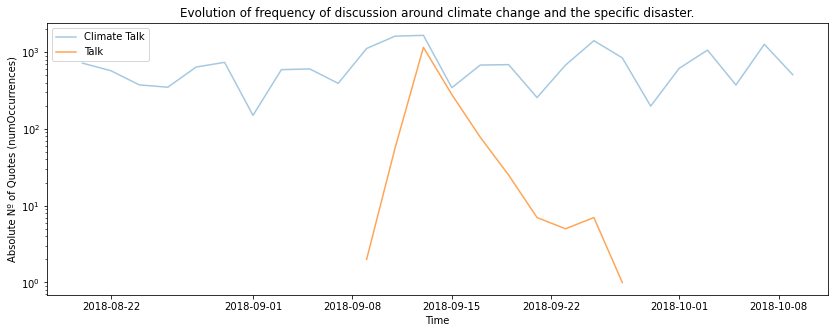

In [205]:
fig = plt.gcf()
fig.set_size_inches(14, 5)

plt.plot(
    climate_df_sampled.date,  
    climate_df_sampled.numOccurrences,
    alpha=0.4,
    label='Climate Talk')
    
plt.plot(
    disaster_df_sampled.date,  
    disaster_df_sampled.numOccurrences,
    alpha=0.7,
    label='Talk')

plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
plt.legend(loc='upper left')
plt.show()